In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import nntools as nt
from PIL import Image
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

Define the variabel 'device', which equals to 'cuda' or 'cpu'.

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# CNN-based Eye Detection

Define the Helen_Dataset class, which is used to load the training or testing dataset.

In [21]:
class Helen_Dataset(td.Dataset):
    
    def __init__(self, root_dir, mode='train', image_size=(448, 448)):
        super(Helen_Dataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.root_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.root_dir+'/data/')
    
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "Helen_Dataset(mode={}, image_size={})". \
        format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir+'/data/', self.files[idx])
        label_path = os.path.join(self.root_dir+'/label/', self.files[idx])
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        dim_diff = np.abs(h - w)
        pad = (0, 0, 0, dim_diff) if h <= w else (0, 0, dim_diff, 0)
        
        transform = tv.transforms.Compose([
        tv.transforms.Pad(padding=pad, fill=0, padding_mode='constant'),
        tv.transforms.Resize(self.image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        img = transform(img)
        label = np.load(label_path+'.npy')
        label = torch.from_numpy(label).float()

        return img, label

In [22]:
train_set = Helen_Dataset(root_dir='./', mode='train', image_size=(448, 448))
test_set = Helen_Dataset(root_dir='./', mode='test', image_size=(448, 448))

The size of the original image is: (1522, 1618, 3)


<Figure size 432x288 with 0 Axes>

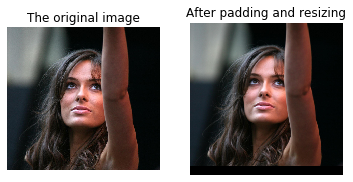

<Figure size 432x288 with 0 Axes>

In [23]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

x = test_set[0]
fig, axes = plt.subplots(ncols=2)

I = plt.imread('./test/data/100032540_1.jpg')
print('The size of the original image is:', np.shape(I))
axes[0].imshow(I)
axes[0].set_title('The original image')
axes[0].axis('off')

myimshow(x[0], ax=axes[1])
plt.title('After padding and resizing')
plt.figure()

In [24]:
class NNDetection(nt.NeuralNetwork):
    # define the loss of the detection model, where BCEWithLogitsLoss() evaluates the performance of classification
    # and SmoothL1Loss() evaluates the results for bounding box prediction (regression)
    
    def __init__(self):
        super(NNDetection, self).__init__()
        self.BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
        self.SmoothL1Loss = nn.SmoothL1Loss()

    def criterion(self, y, d):
        L_clss = self.BCEWithLogitsLoss(y[0,:,:], d[0,:,:])
        L_regr = self.SmoothL1Loss(y[1:5,:,:], d[1:5,:,:])
        return 0.1 * L_clss +  L_regr

In [25]:
class YOLO_Net(NNDetection):
    # The YOLO_Net get a 448*448*3 input, and generate a 5*7*7 output
    
    def __init__(self):
        super(YOLO_Net, self).__init__()
        # Convolutional kernels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        
        self.conv3 = nn.ModuleList([nn.Conv2d(192, 128, kernel_size=1, padding=0),
                                   nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                   nn.Conv2d(256, 256, kernel_size=1, padding=0),
                                   nn.Conv2d(256, 512, kernel_size=3, padding=1)])
        
        self.conv4 = nn.ModuleList()
        for i in range (4):
            self.conv4.append(nn.Conv2d(512, 256, kernel_size=1, padding=0))
            self.conv4.append(nn.Conv2d(256, 512, kernel_size=3, padding=1))
        self.conv4.append(nn.Conv2d(512, 512, kernel_size=1, padding=0))
        self.conv4.append(nn.Conv2d(512, 1024, kernel_size=3, padding=1))
        
        self.conv5 = nn.ModuleList([nn.Conv2d(1024, 512, kernel_size=1, padding=0),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.Conv2d(1024, 512, kernel_size=1, padding=0),
                                   nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                   nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                   nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)])
        
        self.conv6 = nn.ModuleList([nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                  nn.Conv2d(1024, 1024, kernel_size=3, padding=1)])
        
        # Fully-connected layers
        self.fc1 = nn.Linear(7 * 7 * 1024, 2048)  
        self.fc2 = nn.Linear(2048, 7 * 7 * 5)

    def forward(self, x):
        # Conv-block 1
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        
        # Conv-block 2
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        # Conv-block 3
        for conv in self.conv3:
            x = F.relu(conv(x))
        x = F.max_pool2d(x, (2, 2))
        
        # Conv-block 4
        for conv in self.conv4:
            x = F.relu(conv(x))
        x = F.max_pool2d(x, (2, 2))
        
        # Conv-block 5
        for conv in self.conv5:
            x = F.relu(conv(x))
            
        # Conv-block 6
        for conv in self.conv6:
            x = F.relu(conv(x))
        
        # Fully-connected layers
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 5, 7, 7)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [26]:
class StatsManager(nt.StatsManager):
    
    def __init__(self):
        super(StatsManager, self).__init__()
    
    def init(self):
        super(StatsManager, self).init()
        self.running_accuracy = 0
    
    def accumulate(self, loss, x, y, d):
        super(StatsManager, self).accumulate(loss, x, y, d)
    
    def summarize(self):
        loss = super(StatsManager, self).summarize()
        return {'loss': loss}

In [27]:
# define the parameters for training and testing the model
lr = 1e-3
net = YOLO_Net()
net = net.float()
net = net.to(device)
sgd = torch.optim.SGD(net.parameters(), lr=lr)
stats_manager = StatsManager()
exp1 = nt.Experiment(net, train_set, test_set, sgd, stats_manager, output_dir="detection1", batch_size = 5)

In [28]:
# load the model and parameters, test on the first instance of the testing set
exp1.run(num_epochs=50, plot=None)
with torch.no_grad():
    y = net(test_set[0][0].unsqueeze(0).to(device))

In [29]:
# load the target bounding box, mapping the predicted bounding box size to the original image (before resizing)
from get_bounding_box import get_bounding_box
from label_bounding_box import label_bounding_box
from mapping_to_original import mapping_to_original

yd = y.to('cpu').data.numpy()
[bbx, idx] = get_bounding_box(yd)
org_bbx = mapping_to_original(bbx, idx)
boundingBoxes = label_bounding_box(path='./test/', file = '1.csv')

Text(0.5, 1.0, 'Detection Result')

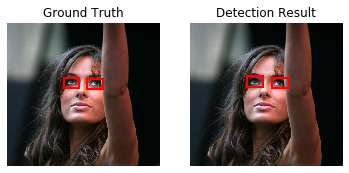

In [30]:
# plotting and comparing the ground truth and detection reulst
from plot_bbx import plot_bbx

img_path = './test/data/100032540_1.jpg'
I = np.asarray(Image.open(img_path).convert('RGB'))

fig,ax = plt.subplots(ncols=2)
plot_bbx(I, boundingBoxes, ax[0])
ax[0].set_title('Ground Truth')
plot_bbx(I, org_bbx, ax[1])
ax[1].set_title('Detection Result')


In [31]:
from IoU import IoU

U = IoU(org_bbx, boundingBoxes)

The IoU for the left eye is 0.691124.
The IoU for the right eye is 0.602055.


We use Intersection over Union (IoU) as the criterion to evaulate the performance of our detection model. Basically, our model could capture rough location of both eyes, and the IoU scores for both eyes are greater than 0.5. As shown in the figures, the detected bounding box for left eye is more close the ground-truth box, and the left one has better IoU performance accordingly.

In [32]:
np.save('bbx.npy',boundingBoxes)
bbx = boundingBoxes.astype('int')

In [33]:
crop_img1 = I[int(bbx[0,1]): int(bbx[0,1]+bbx[0,3]), int(bbx[0,0]): int(bbx[0,0]+bbx[0,2]), :]
crop_img2 = I[int(bbx[1,1]): int(bbx[1,1]+bbx[0,3]), int(bbx[1,0]): int(bbx[1,0]+bbx[1,2]), :]

(105, 160, 3)

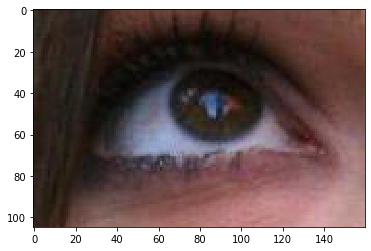

In [34]:
plt.imshow(crop_img1)
np.shape(crop_img1)

In [35]:
from PIL import Image

result = Image.fromarray((crop_img1).astype(np.uint8))
result.save('./SRCNN_test/Set5/out.bmp')